# Свёрточные нейронные сети

Дмитрий Сошников

технологический евангелист, Microsoft

dmitryso@microsoft.com

Данная презентация представляет собой введение в нейронные сети. Идея однодневного мастер-класса основана на Neural Network Workshop в Microsoft Research Cambridge. Материал и фрагменты кода частично взяты из презентаций [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) и [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/) из Microsoft Research Cambridge.

## Основная идея

Если нейросеть имеет дополнительную информацию о струтуре объектов, с которыми она работает, то качество работы возрастает.

  * Распознавание формы вне зависимости от цвета - лучше перейти к ч/б
  * Распознавание котиков на картинке
      - translation invariance - форма котика не зависит от того, в какой части изображения он находится
  * Работа с текстом
      - смысл слова не зависит от его положения в тексте

## Разделение весов (Weight Sharing)

  * Чтобы сети не приходилось отдельно учиться распознавать котиков в разных частях картинки, мы "разделяем" веса, отвечающие за распознавание, между различными фрагментами входных сигналов
  * Это требует специализированной архитектуры сети:
     - свёрточные сети - для работы с изображениями
     - рекуррентные сети - для работы с текстом / последовательностями
     

In [1]:
%matplotlib inline
import builtins
import os
import pickle
import time
import pylab
import cntk
from cntk import Trainer
from cntk.learners import sgd
from cntk.ops import *
from cntk.io import *
from cntk.layers import *
import numpy as np
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed


In [2]:
if not os.path.exists('mnist.pkl'):
    !rm *.pkl
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
    !gzip -d mnist.pkl.gz
        
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

images = MNIST['Train']['Features'].astype(np.float32).reshape(MNIST['Train']['Features'].shape[0],1,28,28)
images /= 255
labels = MNIST['Train']['Labels']
label_names = np.arange(10)

def conv(n):
    return np.array([ 1 if x==n else 0 for x in label_names])

labels = np.array([ conv(x) for x in labels],dtype=np.float32)
        
N = len(labels)*8//10

images_train, images_test = np.split(images, [N])
labels_train, labels_test = np.split(labels, [N])
N_test = labels_test.size

## Свёрточные сети

Нейронные сети, эффективно использующиеся в распознавании изображений, в которых применяются специальные **свёрточные слои** (Convolution Layers).

Основная идея заключается в следующем:

  * Используем *weight sharing* для создания "фильтрующего окна", пробегающего по изображению
  * Применённый к изображению фильтр помогает выделить фрагменты, важные для распознавания
  * В то время как в традиционном машинном зрении фильтры конструировали вручную, нейросети позволяют нам сконструировать оптимальные фильтры с помощью обучения
  * Фильтрацию изображения можно естественным образом совместить с вычислением нейронной сети
  

![GIF](https://www.cntk.ai/jup/cntk103d_conv2d_final.gif)

## 1D-Convolution

Идея свёртки применяется в обработке сигналов

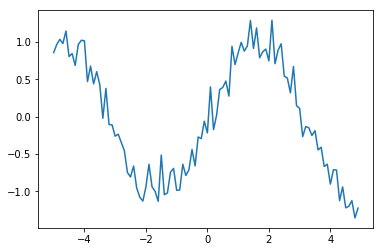

In [3]:
x_values = np.arange(-50, 50) / 10.0
noise = [np.random.normal()/5 for i in range(len(x_values))]
y_values = np.sin(x_values) + noise
pylab.plot(x_values, y_values)
pylab.show()

$$y_i = \sin(x_i) + \epsilon$$
где $\epsilon$ - случайная величина с $\mathbb{E}(\epsilon)=0$.

## Low-pass filter

Для уменьшение шума применим к исходному сигналу фильтр, который будет в каждой точке усреднять значение сигнала по соседним точкам с некоторыми весами. Получим новый сигнал:

$$y'_i = \sum_{j=-3}^3 f_j x_{i+j}$$

При этом $\sum_{j=-3}^3f_j=1$, что означает, что в среднем амплитуда сигнала не изменится.

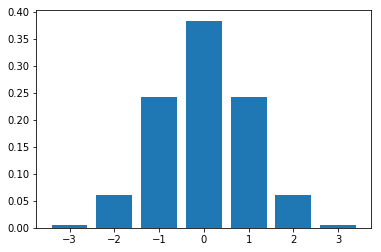

In [4]:
filter_x = np.arange(-3, 4)
filter_y = np.array([.006, .061, .242, .383, .242, .061, .006], dtype='float32')

pylab.bar(filter_x, filter_y)
pylab.show()

In [5]:
def smooth(input_values):
    result = []
    for i in range(3, len(input_values)-3):
        sum = 0.0
        for j in range(7):
            sum += filter_y[j]*input_values[i+j-3]    
        result.append(sum)
    return result

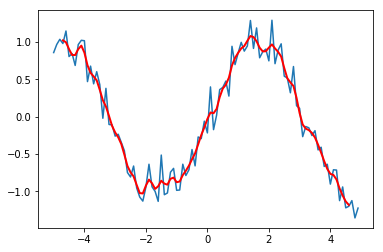

In [6]:
filtered_y_values = smooth(y_values)
pylab.plot(x_values, y_values)
pylab.plot(x_values[3:-3], filtered_y_values, 'r', linewidth=2.0)
pylab.show()

## 2D Convolution

Аналогичный принцип можно применить для двумерной обработки изображений. Опишем функцию, которая осуществляет свёртку, со следующими параметрами:

  * `kernel` - *ядро свёртки*, матрица весов
  * `pad` - сколько пискелей надо добавить к изображению по краям
  * `stride` - частота применения фильтра. Например, для `stride=2` будем брать каждый второй пиксель изображения по вертикали и горизонтали, уменьшив разрешение вдвое

In [7]:
def convolve(image, kernel, pad = 0, stride = 1):
    rows, columns = image.shape
    output_rows = rows // stride
    output_columns = columns // stride
    result = np.zeros((output_rows, output_columns))
    if pad > 0:
        image = np.pad(image, pad, 'constant')    
    kernel_size = kernel.size
    kernel_length = kernel.shape[0]
    half_kernel = kernel_length // 2  
    kernel_flat = kernel.reshape(kernel_size, 1)
    offset = builtins.abs(half_kernel-pad)
    for r in range(offset, rows - offset, stride):
        for c in range(offset, columns - offset, stride):
            rr = r - half_kernel + pad
            cc = c - half_kernel + pad  
            patch = image[rr:rr + kernel_length, cc:cc + kernel_length]
            result[r//stride,c//stride] = np.dot(patch.reshape(1, kernel_size), kernel_flat)            
    return result

In [8]:
def show_convolution(kernel, stride = 1):
    """Displays the effect of convolving with the given kernel."""
    fig = pylab.figure(figsize = (9,9))
    gs = gridspec.GridSpec(3, 3, height_ratios=[3,1,3])
    start=1
    for i in range(3):        
        image = images_train[start+i,0]
        conv = convolve(image, kernel, kernel.shape[0]//2, stride)
        ax = fig.add_subplot(gs[i])
        pylab.imshow(image, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax = fig.add_subplot(gs[i + 3])
        pylab.imshow(kernel, cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax = fig.add_subplot(gs[i + 6])
        pylab.imshow(conv, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])        
    pylab.show()

In [9]:
blur_kernel = np.array([[1, 4, 7, 4, 1],
                        [4, 16, 26, 16, 4],
                        [7, 26, 41, 26, 7],
                        [4, 16, 26, 16, 4],
                        [1, 4, 7, 4, 1]], dtype='float32')
blur_kernel /= 273

### Blur

Фильтр размытия позволяет сгладить неровности и подчеркнуть общую форму объектов...

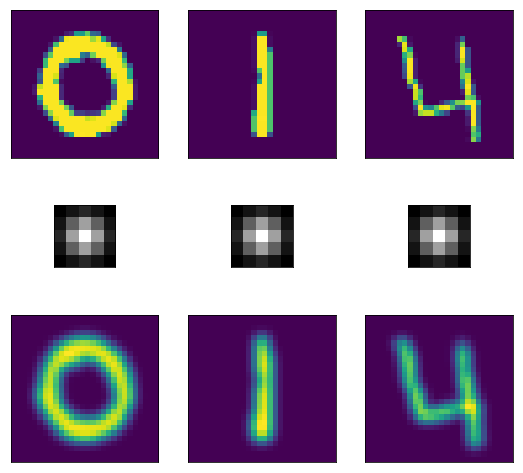

In [10]:
show_convolution(blur_kernel)

### Вертикальные края

Можно придумать фильтр, выделяющий вертикальные переходы яркости на изображении. Здесь голубой цвет обозначает переход от чёрного к белому, жёлтый - наоборот.

In [11]:
vertical_edge_kernel = np.array([[1, 4, 0, -4, 1],
                                   [4, 16, 0, -16, -4],
                                   [7, 26, 0, -26, -7],
                                   [4, 16, 0, -16, -4],
                                   [1, 4, 0, -4, -1]], dtype='float32')
vertical_edge_kernel /= 166

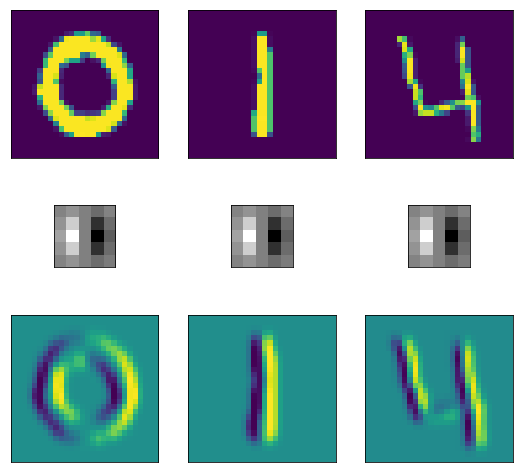

In [12]:
show_convolution(vertical_edge_kernel)

## Горизонтальные края
Аналогичный фильтр можно построить для выделения горизонтальных штрихов на изображении.

In [13]:
horizontal_bar_kernel = np.array([[0, 0, 0, 0, 0],
                                 [-2, -8, -13, -8, -2],
                                 [4, 16, 26, 16, 4],
                                 [-2, -8, -13, -8, -2],
                                 [0, 0, 0, 0, 0]], dtype='float32')
horizontal_bar_kernel /= 132

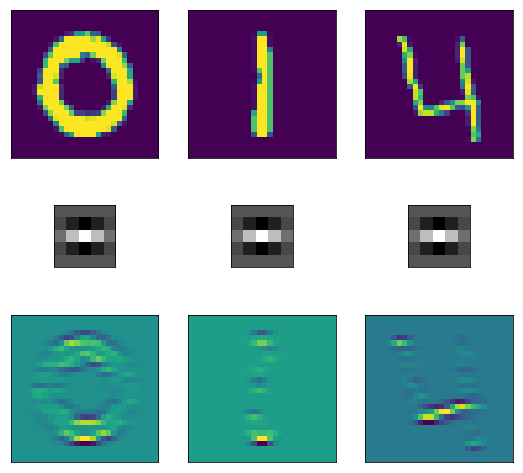

In [14]:
show_convolution(horizontal_bar_kernel)

## Контурный фильтр

Также можно построить фильтр 9x9, который будет выделять контуры изображения.

In [15]:
blob_kernel = np.array([[0, 1, 1, 2, 2, 2, 1, 1, 0],
                       [1, 2, 4, 5, 5, 5, 4, 2, 1],
                       [1, 4, 5, 3, 0, 3, 5, 4, 1],
                       [2, 5, 3, -12, -24, -12, 3, 5, 2],
                       [2, 5, 0, -24, -40, -24, 0, 5, 2],
                       [2, 5, 3, -12, -24, -12, 3, 5, 2],
                       [1, 4, 5, 3, 0, 3, 5, 4, 1],
                       [1, 2, 4, 5, 5, 5, 4, 2, 1],
                       [0, 1, 1, 2, 2, 2, 1, 1, 0]], dtype='float32')
blob_kernel /= np.sum(np.abs(blob_kernel))

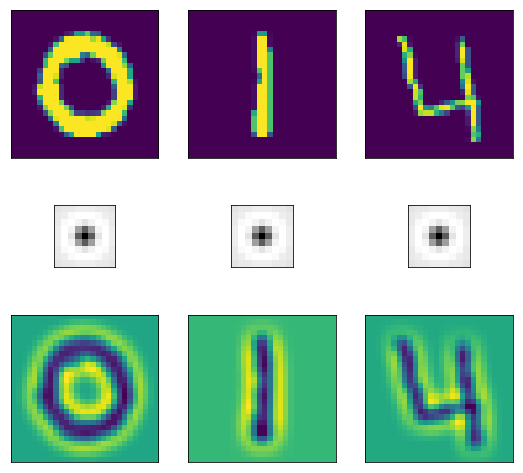

In [16]:
show_convolution(blob_kernel)

## Банки фильтров и биологическое зрение

<img style="width:100%;align=center" src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ext/lmfilters.jpg" alt="Leung Malik Filter Bank" />


 ## Банки фильтров
 
 * С помощью разных фильтров можно выделять различные фрагменты изображения, которые затем обнаруживать и исследовать в виде отдельных свойств
     - Например, подавать на вход традиционному машинному обучению или нейросетям
 * В области машинного зрения наработаны **банки фильтров** - наборы фильтров для выделения основных фич
 * В биологическом зрении, оказывается, используется похожая "архитектура"

## Основная идея свёрточной сети

  * Делаем в нейросети свёрточный слой, который обеспечивает применение фильтра к изображению
  * Веса фильтра обучаются по тому же алгоритму обратного распространения
 

## Свёрточный слой

Рассмотрим простое изображение $i$, и 2 свёрточных фильтра $w$ с выходами $o$:

![Convolution Example](https://msrcdlw.blob.core.windows.net/data/convolutionExample.png "Convolution Example")

Тогда элементы выходного изображения вычисляются следующим образом:

$$
\begin{align*}
o_{f,r,c} &= w_{f00}i_{r-1,c-1} + w_{f01}i_{r-1,c} + w_{f02}i_{r-1,c+1} \\
         &~~+ w_{f10}i_{r,c-1} + w_{f11}i_{r,c} + w_{f12}i_{r,c+1} \\
         &~~+ w_{f20}i_{r+1,c-1} + w_{f21}i_{r+1,c} + w_{f22}i_{r+1,c+1}
\end{align*}
$$

## Тренировка весов

  * Фильтр с одними и теми же весами применяется ко всем пикселям изображения
  * При этом фильтр "пробегает" по всему изображению
  * Мы хотим обучать эти веса (общие для всех пикселей) по алгоритму обратного распространения
  * Для этого надо свести применение фильтра к однократному умножению матриц
  * В отличие от полносвязного слоя, весов для обучения будет меньше, а примеров - больше
  * Хитрость - `im2col`

## im2col

Начнем с изображения $\mathbf{x}$, где каждый пиксель соответствует букве:

$$
\mathbf{x} = \left(
         \begin{array}{ccccc}
           a & b & c & d & e \\
           f & g & h & i & j \\
           k & l & m & n & o \\
           p & q & r & s & t \\
           u & v & w & x & y \\
         \end{array}
     \right)
$$

## im2col
Мы извлечем все фрагменты изображения $3\times3$ и поместим их в столбцы большой матрицы $\mathbf{X}$:

$$
\mathbf{X} = \left[
        \begin{array}{cccccc}
          a & b & \ldots & g & \ldots & m \\
          b & c & \ldots & h & \ldots & n \\
          c & d & \ldots & i & \ldots & o \\
          f & g & \ldots & l & \ldots & r \\
          g & h & \ldots & m & \ldots & s \\
          h & i & \ldots & n & \ldots & t \\
          k & l & \ldots & q & \ldots & w \\
          l & m & \ldots & r & \ldots & x \\
          m & n & \ldots & s & \ldots & y \\
        \end{array}
    \right]
$$

## im2col
Теперь мы можем сохранить веса фильтров в обычной матрице, где каждая строка соответствует одному свёрточному фильтру:

$$
\mathbf{W}_i = \left[
         \begin{array}{cccccccc}
            w_{000} & w_{001} & w_{002} & w_{010} & w_{011} & \ldots & w_{021} & w_{022} \\
            w_{100} & w_{101} & w_{102} & w_{110} & w_{111} & \ldots & w_{121} & w_{122} \\
         \end{array}
       \right]
$$

Тогда свёртка по всему изображению превращается в обычное матричное умножение:

$$
C_i(\mathbf{x}) = \mathbf{W}_i\mathbf{X} = \mathbf{W}_i \mathrm{im2col} (\mathbf{x})
$$

## Свёрточные сети в CNTK

Для использования свёрточного слоя в Cognitive Toolkit достаточно использовать конструкцию, задающую свёрточный слой, вместо обычного полносвязного слоя `Dense`

In [3]:
model = Sequential([
          Convolution((5,5),9,init=glorot_uniform(),activation=relu,name='conv'),
          Dense(10, init=glorot_uniform(),activation=None,name='dense')])
model.update_signature((1,28,28))

  ## Размеры сети
  
  * (5,5) - размер окна фильтра
  * 9 - количество фильтров
  * (1,28,28) - размер входной переменной
  
 ![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)


In [4]:
def evaluate(x):
    return np.average(x.eval({x.arguments[0]:images_test,x.arguments[1]:labels_test}))

def train(model,epochs=20):
    minibatch_size = 64
    input_var = input_variable((1,28,28))
    label_var = input_variable(10)
    
    z = model(input_var)

    ce = cntk.cross_entropy_with_softmax(z, label_var)
    pe = cntk.classification_error(z, label_var)
    lr_per_minibatch = cntk.learning_rate_schedule(0.01, cntk.UnitType.minibatch)
    pp = cntk.logging.ProgressPrinter(num_epochs=epochs)
    
    learner = cntk.sgd(z.parameters, lr = lr_per_minibatch)
    trainer = cntk.Trainer(z, (ce, pe), [learner],[pp])
    cntk.logging.log_number_of_parameters(z)
    progress = []
    for epoch in range(epochs):
        perm = np.random.permutation(len(labels_train))
        taccuracy = 0; tloss = 0; cnt = 0
        for i in range(0, len(labels_train), minibatch_size):
            max_n = min(i + minibatch_size, len(labels_train))
            x = images_train[perm[i:max_n]]
            t = labels_train[perm[i:max_n]]
            trainer.train_minibatch({input_var:x,label_var:t})
            tloss += trainer.previous_minibatch_loss_average*trainer.previous_minibatch_sample_count
            taccuracy += trainer.previous_minibatch_evaluation_average*trainer.previous_minibatch_sample_count
            cnt+=trainer.previous_minibatch_sample_count
            pp.update_with_trainer(trainer,with_metric=True)
        vloss = evaluate(ce)
        vacc = evaluate(pe)
        progress.append([tloss/cnt,taccuracy/cnt,vloss,vacc])
        pp.epoch_summary(with_metric=True)
    return progress

In [5]:
progress = train(model,5)

Training 52084 parameters in 4 parameter tensors.
Learning rate per minibatch: 0.01
Finished Epoch[1 of 5]: loss = 0.707862 * 33600, metric = 19.61% * 33600 24.427s (1375.5 samples/s);
Finished Epoch[2 of 5]: loss = 0.356193 * 33600, metric = 10.37% * 33600 7.890s (4258.5 samples/s);
Finished Epoch[3 of 5]: loss = 0.330236 * 33600, metric = 9.57% * 33600 8.251s (4072.2 samples/s);
Finished Epoch[4 of 5]: loss = 0.312831 * 33600, metric = 9.10% * 33600 8.404s (3998.0 samples/s);
Finished Epoch[5 of 5]: loss = 0.297274 * 33600, metric = 8.58% * 33600 8.127s (4134.4 samples/s);


In [6]:
def plot_progress(progress):
    progress = np.array(progress)
    x = range(len(progress))
    pylab.figure(figsize=(10,5))
    pylab.subplot(1,2,1)
    pylab.plot(x, progress[:,0], 'k--')
    pylab.plot(x, progress[:,2], 'g-')
    pylab.legend(['training', 'validation'], loc='upper center', ncol = 2)    
    pylab.title('Loss')
    pylab.subplot(1,2,2)
    pylab.plot(x, progress[:,1], 'k--')
    pylab.plot(x, progress[:,3], 'g-')
    pylab.legend(['training', 'validation'], loc='upper center', ncol = 2)    
    pylab.title('Error')
    pylab.show()

In [ ]:
plot_progress(progress)

In [22]:
def evaluate_model(model, num_examples = 8):
    images = images_test[0:num_examples]
    input_var = model.arguments[0]
    p = cntk.softmax(model(input_var))
    output = p.eval({input_var: images})
    if images[0].shape[0] == 3: # cifar
        output = output[0]
    fig = pylab.figure(figsize = (12,2))
    gs = gridspec.GridSpec(2, num_examples, height_ratios=[2,1])
    
    for i in range(num_examples):
        ax = fig.add_subplot(gs[0, i])
        if images[i].shape[0] == 3: # cifar
            reorder = np.swapaxes((images[i]+128.)/256., 0, 1)
            reorder = np.swapaxes(reorder, 1, 2)
            pylab.imshow(reorder, interpolation='nearest')
        else:
            pylab.imshow(images[i].reshape(images[i].shape[1:]), cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax = fig.add_subplot(gs[1, i])
        pylab.bar(np.arange(10), output[i])
        locs, labels = pylab.xticks(np.arange(10), label_names)
        if len(str(label_names[0])) > 1:
            pylab.setp(labels, rotation=90)
        ax.set_yticks([])

    pylab.show()

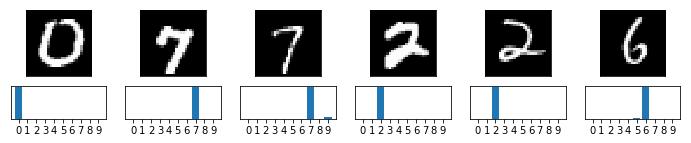

In [23]:
evaluate_model(model,6)

## Погружаемся в магию

Чтобы немного понять, как работают фильтры, посмотрим на то, каким фильтрам научилась модель, и что происходит с изображением по ходу вычислений.

In [24]:
def mapeval(x):
    return np.array([ x[i].eval()[0] for i in range(x.shape[0])])

def filters_grid(inp, fig, cell):
    num_filters = inp.shape[0]
    num_channels = inp.shape[1]
    size = inp.shape[2]
    inpe = mapeval(inp)
    #print("F> {}".format(inpe.shape))

    side = int(np.sqrt(num_filters))
    if num_filters > side*side:
        side += 1
    cside = int(np.sqrt(num_channels))
    if num_channels > cside*cside:
        cside += 1
    grid = gridspec.GridSpecFromSubplotSpec(side, side, subplot_spec=cell)
    for i in range(num_filters):
        ax = pylab.Subplot(fig, grid[i])
        composite = np.zeros((cside*size, cside*size), dtype='float32')
        for j in range(num_channels):
            r = (j // cside)*size
            c = (j % cside)*size
            composite[r:r + size, c:c + size] = inpe[i,j]
        ax.imshow(composite, cmap='gray', interpolation='nearest')            
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)  

def images_grid(inp, fig, cell):
    if len(inp.shape)>3:
        inp = inp[0]
    num_channels = inp.shape[0]
    size = inp.shape[1]
    #print("I> {}".format(inp.shape))
    if num_channels == 3:
        inp = np.swapaxes(inp, 0, 1)
        inp = np.swapaxes(inp, 1, 2)
        inp = np.clip(inp,0,1)
        ax = pylab.Subplot(fig, cell)
        ax.imshow(inp, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])        
        fig.add_subplot(ax)
    else:
        side = int(np.sqrt(num_channels))
        if num_channels > side*side:
            side += 1
        grid = gridspec.GridSpecFromSubplotSpec(side, side, subplot_spec=cell, wspace=0.1, hspace=0.1)
        for i in range(num_channels):
            ax = pylab.Subplot(fig, grid[i])
            ax.imshow(inp[i], interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            
def visualize_output(model, index, widths, heights,layers,conv):    
    fig = pylab.figure(figsize = (np.sum(widths),np.sum(heights)))
    gs = gridspec.GridSpec(len(heights), len(widths), 
                           width_ratios=widths, height_ratios=heights)
    
    img = images_test[index]
    if (img.shape[1]==28): x = input_variable(img.shape)
    else: x = cntk.sequence.input_variable(img.shape)
    images_grid(img, fig, gs[0,1])
    func = None
    for i in range(0,len(layers)):
        #print("Layer {}".format(layers[i]))
        if conv[i]==None: # Pooling
            pass
        elif conv[i]: # Convolution layer
            weights = layers[i].W
            filters_grid(weights, fig, gs[i+1,0])
        else:
            weights = layers[i].W
            ax = pylab.Subplot(fig, gs[i+1,0])
            weightsx = mapeval(weights)
            if len(weightsx.shape)>3:
                weightsx = np.rollaxis(weightsx,3).reshape(weightsx.shape[0],-1)
            ax.imshow(weightsx, cmap='gray', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

        if func==None:
            func = layers[i]
        else:
            func = layers[i] << func
        output = func(x).eval({x:img})[0]
        #output = func(xs).eval({xs:img})[0]
        if conv[i]==None:
            images_grid(output,fig,gs[i+1,1])
        elif conv[i]:
            images_grid(output, fig, gs[i+1,1])
        else:
            ax = pylab.Subplot(fig, gs[i+1,1])
            if i < len(layers)-1:
                output = output.reshape(8, 8)
            else:
                output = output.reshape(1, 10)
            ax.imshow(output, interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)            
    
    pylab.show()
    
def visualize_mnist_output(model, index):
    visualize_output(model, index, [8,2],[1,3,1],[model.conv,model.dense],[True,False])

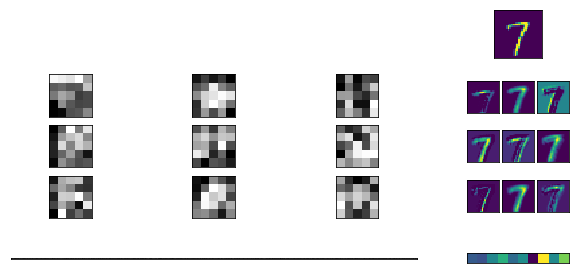

In [25]:
visualize_mnist_output(model,2)

## Выводы

  * Некоторые фильтры выглядят похожими на рассмотренные нами ранее, но при этом они имеют сложную природу
  * По выходным изображениям иногда можно понять, что именно обнаруживает фильтр
  * Размерность свёрточного слоя невелика: $9\times5\times5=225$ параметров
  * Размерность финального слоя: $9\times24\times24=5184$. Это требует большого количества примеров для обучения, т.к. количество примеров зависит от количества параметров модели
  * Неплохо бы научиться уменьшать размерность выходного слоя!

## Субдискретизация (Subsampling)

Для уменьшения размера последующих слоёв после свёртки обычно используют субдискретизацию, оставляя лишь каждое $n$-ое значение из результирующих пикселей по горизонтали и вертикали. Это обычно не ведёт к существенной потере информации.

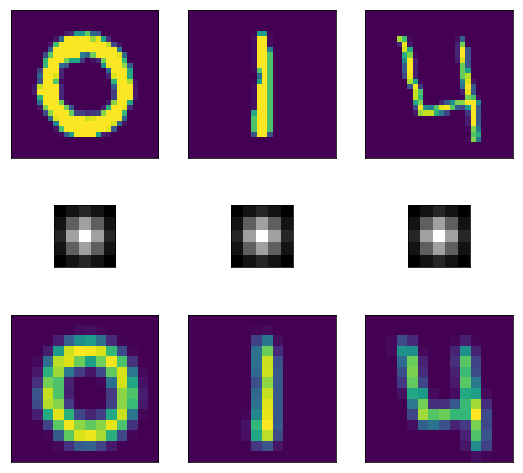

In [26]:
show_convolution(blur_kernel, stride=2)

## Субдискретизирующие слои (Pooling Layers)

 * Можно в процессе свёртки идти по изображению с некоторым шагом (*stride*), но это приводит к потере информации
 * Для внесения субдискретизации обычно добавляют специальные слои, которые называются **субдискретизирующими** (Pooling).
 * Уменьшение размерности вдвое ведет к уменьшению числа параметров в 4 раза!
 
Обычно применяются следующие виды субдискретизирующих слоёв:
 * Average Pooling
 * Max Pooling

## Average and Max Pooling

![Average and max pooling](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ext/avmaxpool.jpg)

## Average Pooling

  * Размер фильтра size = 3
  * Шаг stride = 2

Такой слой является *непараметрическим* (в нём нет параметров для обучения), и выполняет роль, похожую на слои нелинейности. Выходные элементы вычисляются как
$$o[r,c] = \frac{1}{9}\sum_{k = 0}^{3} \sum_{l = 0}^{3} i[2r + k - 1, 2c + l - 1]$$

С точки зрения матричных операций это эквивалентно умножению на константную матрицу

$$\mathbf{W} = \left(W_{i,j}~|~W_{i,j} = \frac{1}{9}\right)$$

## Пробуем Max Pooling

In [27]:
model = Sequential([
          Convolution((5,5),9,init=glorot_uniform(),activation=relu,name='conv'),
          MaxPooling((2,2),strides=2,name='pool'),
          Dense(10, init=glorot_uniform(),activation=None,name='dense')])
model.update_signature((1,28,28))

Training 13204 parameters in 4 parameter tensors.
Learning rate per minibatch: 0.01
Finished Epoch[1 of 5]: loss = 1.126802 * 33600, metric = 31.49% * 33600 23.465s (1431.9 samples/s);
Finished Epoch[2 of 5]: loss = 0.389048 * 33600, metric = 11.19% * 33600 21.886s (1535.2 samples/s);
Finished Epoch[3 of 5]: loss = 0.339918 * 33600, metric = 9.93% * 33600 24.596s (1366.1 samples/s);
Finished Epoch[4 of 5]: loss = 0.315796 * 33600, metric = 9.27% * 33600 26.455s (1270.1 samples/s);
Finished Epoch[5 of 5]: loss = 0.298056 * 33600, metric = 8.71% * 33600 25.388s (1323.5 samples/s);


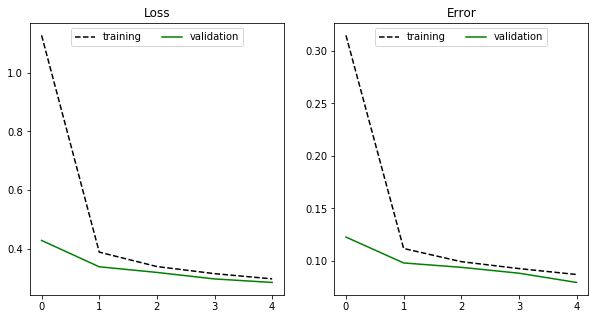

In [28]:
progress = train(model,5)
plot_progress(progress)

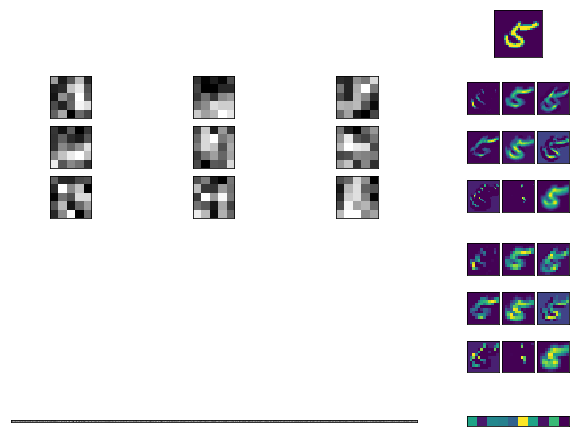

In [29]:
visualize_output(model, 6, [8,2],[1,3,3,1],[model.conv,model.pool,model.dense],[True,None,False])

## Многослойная свёртка

  * В больших сетях используют много свёрточных слоёв, один после другого
  * Посмотрим, как происходит вычисление сети с двумя свёрточными слоями

In [30]:
model = Sequential([
          Convolution((5,5),9,init=glorot_uniform(),activation=relu,name='conv1'),
          MaxPooling((2,2),strides=2,name='pool1'),
          Convolution((5,5),9,init=glorot_uniform(),activation=relu,name='conv2'),
          MaxPooling((2,2),strides=2,name='pool2'),
          Dense(10, init=glorot_uniform(),activation=None,name='dense')])
progress=train(model,5)

Training 3718 parameters in 6 parameter tensors.
Learning rate per minibatch: 0.01
Finished Epoch[1 of 5]: loss = 1.430393 * 33600, metric = 45.72% * 33600 36.606s (917.9 samples/s);
Finished Epoch[2 of 5]: loss = 0.378937 * 33600, metric = 11.37% * 33600 38.029s (883.5 samples/s);
Finished Epoch[3 of 5]: loss = 0.264577 * 33600, metric = 7.83% * 33600 36.690s (915.8 samples/s);
Finished Epoch[4 of 5]: loss = 0.211336 * 33600, metric = 6.27% * 33600 38.222s (879.1 samples/s);
Finished Epoch[5 of 5]: loss = 0.180997 * 33600, metric = 5.42% * 33600 32.849s (1022.9 samples/s);


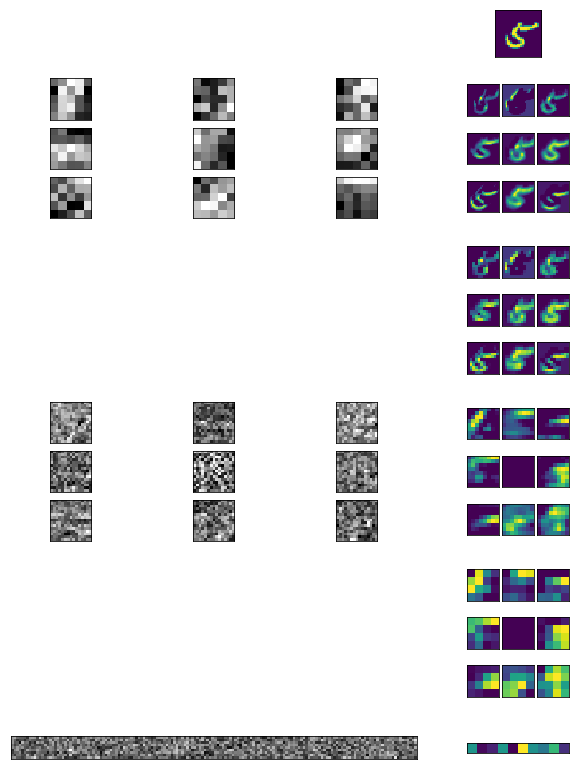

In [31]:
visualize_output(model, 6, [8,2],[1,3,3,3,3,1],[model.conv1,model.pool1,model.conv2,model.pool2,model.dense],[True,None,True,None,False])

## CIFAR-10

Следующий уровень сложности в распознавании изображений - набор CIFAR-10 (Canadian Institute for Advanced Research)

  * Подмножество CIFAR-100 - набор из почти 80 миллионов цветных картинок $32\times32$, взятых из интернет, и размеченных на 75,062 множеств, помеченных существительными
  * CIFAR-10 - 10 классов, 60000 изображений $3\times32\times32$
  * http://www.cs.toronto.edu/~kriz/cifar.html



## CIFAR-10

![](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ext/cifar-10.png)

## Going Deeper

Для распознавания такого набора нам понадобится более сложная архитектура сети с несколькими свёрточными слоями. При этом она будет стоиться из тех же блоков, что мы видели ранее:

![CIFAR-10 DNN](https://msrcdlw.blob.core.windows.net/data/cifar10_dnn.png "CIFAR-10 DNN")

<table>
  <tr><th>C1</th><td>Выделение низкоуровневых сущностей из изображения: углов и краёв</td></tr>
  
  <tr><th>P2</th><td>Обеспечивает гибкость в местоположении конкретных фич</td></tr>
  
  <tr><th>C3</th><td>Ищем шаблоны во взаимном расположении фич предыдущего уровня</td></tr>
  
  <tr><th>P3</th><td>Сглаживает ответ перед субдискретизацией</td></tr>
  
  <tr><th>C5</th><td>Ищем стуктуры верхнего уровня</td></tr>
  
  <tr><th>P6</th><td>Сглаживает и понижает размерность ответов. Выходом этого финального слоя является специальный вектор фич длины 1024, специфичный для CIFAR-10</td></tr>
      
  <tr><th>F7</th><td>Классификатор подкатегория</td></tr>
  
  <tr><th>F8</th><td>Финальный классификатор</td></tr>
</table>

In [32]:
model = Sequential([
    Convolution((5,5), 32, init=glorot_uniform(), pad=True, activation=relu, name='conv1'),
    MaxPooling((3,3),strides=(2,2),pad=True,name='pool1'),
    Convolution((5,5), 32, init=glorot_uniform(), pad=True, activation=relu, name='conv2'),
    MaxPooling((3,3),strides=(2,2),pad=True,name='pool2'),
    Convolution((5,5), 64, init=glorot_uniform(), pad=True, activation=relu, name='conv3'),
    MaxPooling((3,3),strides=(2,2),pad=True,name='pool3'),
    Dense(64, init=glorot_uniform(),activation=relu,name='dense1'),
    Dense(10, init=glorot_uniform(), activation=None, name='dense2')
])

#!rm CIFAR-10.*.model

if not os.path.exists('CIFAR-10.3conv.model'):
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Models/CIFAR-10.3conv.model

model = load_model('CIFAR-10.3conv.model')

Мы используем готовую модель, поскольку её обучение (50 эпох по 50K изображений) занимает около 15 минут на Azure N-Series GPU.

In [33]:
if not os.path.exists('cifar-cat.png'):
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/cifar-cat.png
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/cifar-dog.png
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/cifar-truck.png

fnames = ['cifar-cat.png','cifar-dog.png','cifar-truck.png']
        
from PIL import Image

images_test = [(np.asarray(Image.open(x)).astype(np.float32)-128.) for x in fnames]
images_test = np.array([np.transpose(x,(2,0,1)) for x in images_test])

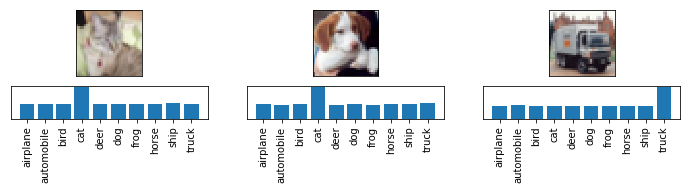

In [34]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
evaluate_model(model,3)

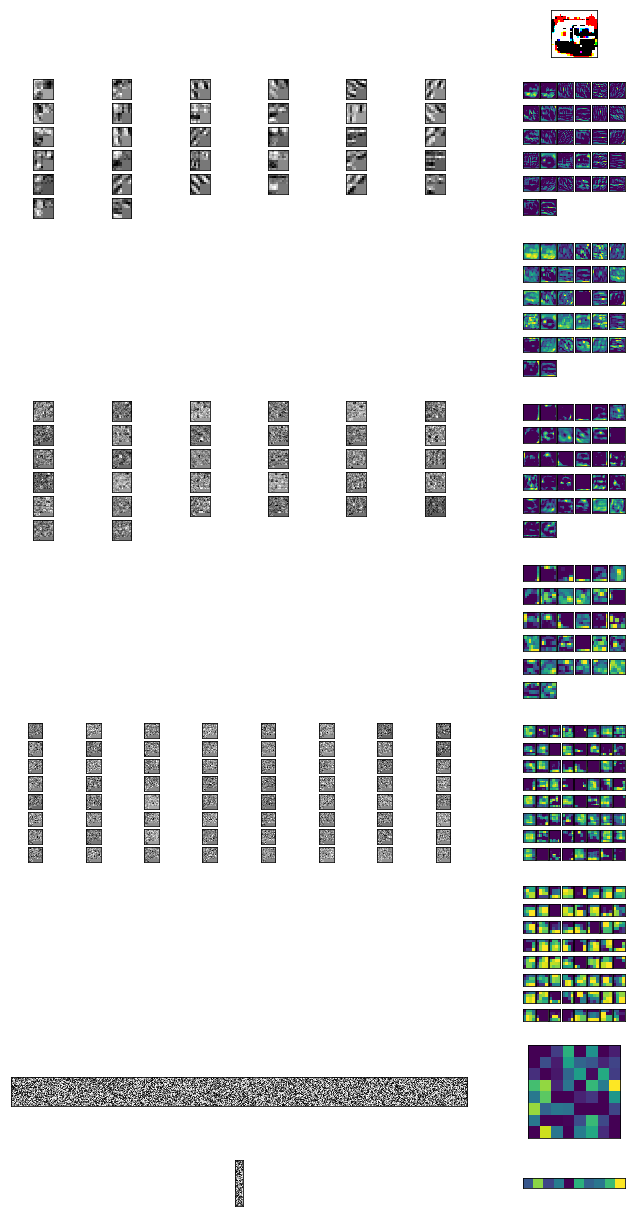

In [35]:
visualize_output(model, 2, [9,2],[1,3,3,3,3,3,3,2,1],[model.conv1,model.pool1,model.conv2,model.pool2,model.conv3,model.pool3,model.dense1,model.dense2],[True,None,True,None,True,None,False,False])

## Как это выглядит

Если взять и проследить процесс распознавания фич в обратном направлении, то можно увидеть, распознаванием какого рода объектов занимается каждый слой

![Feature Extraction from CNN](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/FeatureExtractionCNN.png)

## Функциональный способ задания сети

Для сложных многослойных сетей имеет смысл использовать высокоуровневой способ комбинирования слоёв при помощи конструкций `Sequential`, `For`, `LayerStack` и др.

In [36]:
model = Sequential([
    For(range(3), lambda i: [
        Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True,activation=relu),
        MaxPooling((3,3), strides=(2,2))
    ]),
    Dense(64, init=glorot_uniform(),activation=relu),
    Dense(10, init=glorot_uniform(), activation=None)
])

## Классическая архитектура сети - VGG-16

![VGG-16](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/vgg16.png)

  * По мере прохождения через сеть уменьшается пространственная размерность картинки
  * При этом увеличивается размерность в пространстве признаков
  * Поэтому такую архитектуру называют *пирамидой*

## ImageNet

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ext/imagenet.png" alt="ImageNet" align="right" width="40%" style="margin:10px"/>
Набор данных ImageNet - это:

14 миллионов изображений

20,000 категорий

Изображения очень разные из различных интернет-источников, размечены вручную. 

На базе ImageNet с 2010 г. проводятся соревнования


## Обнаружение

Необходимо указать для каждого из изображений объекты (из 200 категорий) и их местоположение на картинке

<table>
<tr><th>Team Name</th><th># Categories</th><th>Mean AP</th></tr>
<tr><td>MSR Asia</td><td>194</td><td>0.621</td></tr>
<tr><td>Qualcomm Research</td><td>4</td><td>0.536</td></tr>
<tr><td>CUImage</td><td>2</td><td>0.527</td></tr>
</table>

## Классификация
Необходимо указать, к какому классу принадлежит изображение (из 1000 классов)

<table>
<tr><th>Team Name</th><th>Error</th></tr>
<tr><td>MSR Asia</td><td>0.0357</td></tr>
<tr><td>ReCeption</td><td>0.0358</td></tr>
<tr><td>Trips-Soushen</td><td>0.0458</td></tr>
</table>

## Выводы

* Свёрточные сети хорошо подходят для анализа изображений (но не только)
* Мы изучили основные блоки свёрточных сетей:
    - Convolution Layer
    - Pooling Layer (Max Pooling, Ave Pooling)
    - Dense Layers
* При увеличении числа слоёв начинает возникать множество проблем:
    - Затухание градиента
    - Сдвиг диапазона сигналов из "рабочей" зоны
    - Слишком большое число параметров
    - Застревание в локальных минимумах
    
О решении этих проблем поговорим в следующей лекции